In [20]:
# mostly pulled from hls4ml_3.ipynb and waveform_demo.ipynb
# last updated 2025-05-05 by mza
name = "mza_try8"
num_epochs = 10000
batch_size = 1000
hidden_nodes = [ 64 ]
hidden_node_type = "relu"
truths_to_use = [ 3 ] # t_peak, t_sigma, height, pedestal
use_pruning = False
prune_ratio = 0.1
train = True
synth_hls = True
integer_part = 1
input_quantization = 9
inner_quantization = 9
output_quantization = 12

In [2]:
import os, errno
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'
os.environ['PATH'] = os.environ['XILINX_VIVADO'] + '/bin:' + os.environ['PATH']
import numpy as np
seed = 0
np.random.seed(seed)
import matplotlib.pyplot as plt
try:
    os.mkdir(name)
except OSError as exception:
    if exception.errno != errno.EEXIST:
        raise

In [3]:
dataset1 = np.load('waveform_data_0.npy') # (10000, 104)
dataset2 = np.load('waveform_data_1.npy') # (10000, 104)
dataset = np.concatenate((dataset1, dataset2))
num_waveforms = len(dataset)
training_quantity = int(0.8 * num_waveforms)
num_truths = 4
time_samples = len(dataset[0]) - num_truths
print("num_waveforms: " + str(num_waveforms))
num_truths_to_use = len(truths_to_use)
print("num_truths_to_use: " + str(num_truths_to_use))
waveforms = dataset[:,num_truths:]
truths = dataset[:,:num_truths]
waveform_min = min([ min(waveforms[i]) for i in range(len(waveforms)) ])
waveform_max = max([ max(waveforms[i]) for i in range(len(waveforms)) ])
offset = waveform_min
gain = 1.0 / (waveform_max - waveform_min)
scaled_waveforms = np.array([ [ gain * (waveforms[j,i] - offset) for i in range(time_samples) ] for j in range(num_waveforms) ])
scaled_truths = np.array([ [ truths[j,0]/time_samples, truths[j,1]/time_samples, gain * (truths[j,2] - offset), gain * (truths[j,3] - offset) ] for j in range(num_waveforms) ])
train_data = scaled_waveforms[:training_quantity,:]
print("train_data.shape: " + str(train_data.shape))
train_truth = scaled_truths[:training_quantity,truths_to_use]
print("train_truth.shape: " + str(train_truth.shape))
test_data = scaled_waveforms[training_quantity:,:]
print("test_data.shape: " + str(test_data.shape))
test_truth = scaled_truths[training_quantity:,truths_to_use]
print("test_truth.shape: " + str(test_truth.shape))

num_waveforms: 20000
num_truths_to_use: 1
train_data.shape: (16000, 100)
train_truth.shape: (16000, 1)
test_data.shape: (4000, 100)
test_truth.shape: (4000, 1)


In [4]:
evt = 8
if 0:
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = train_data[evt]
    plt.xlim(0, 1), plt.ylim(0, 1)
    plt.scatter(x, y)
    plt.plot([train_truth[evt][0], train_truth[evt][0]], [0.0, 1.0], color="green")
    plt.show()

In [5]:
print("time position of the peak: ", train_truth[evt][0]) # The 0th column: mean of the Gaussian peak

time position of the peak:  0.1934534782372811


In [6]:
import tensorflow as tf
tf.random.set_seed(seed)
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l1
from tensorflow.keras.layers import Activation
from tensorflow.keras import optimizers
from callbacks import all_callbacks
from qkeras.qlayers import QDense, QActivation
from qkeras.quantizers import quantized_bits, quantized_relu, quantized_sigmoid

In [7]:
input_quantizer = quantized_bits(input_quantization, integer_part, alpha=1)
inner_quantizer = quantized_bits(inner_quantization, integer_part, alpha=1)
output_quantizer = quantized_bits(output_quantization, integer_part, alpha=1)
output_quantization_string = 'ap_fixed<' + str(output_quantization) + ',' + str(integer_part) + '>'
if hidden_node_type=="relu":
    hidden_activations = [ quantized_relu(inner_quantization) for i in range(len(hidden_nodes)) ]
else:
    hidden_activations = [ quantized_sigmoid(inner_quantization) for i in range(len(hidden_nodes)) ]
hidden_names = [ hidden_node_type for i in range(len(hidden_nodes)) ]
model = Sequential()
model.add(QDense(time_samples, input_shape=(time_samples,), name='input_qdense', kernel_quantizer=input_quantizer, bias_quantizer=input_quantizer, kernel_initializer='glorot_uniform'))
model.add(QActivation(activation=quantized_sigmoid(input_quantization), name='input_sigmoid'))
for i in range(len(hidden_nodes)):
    model.add(QDense(hidden_nodes[i], name=hidden_names[i] + str(i) + "qdense", kernel_quantizer=inner_quantizer, bias_quantizer=inner_quantizer, kernel_initializer='glorot_uniform'))
    model.add(QActivation(activation=hidden_activations[i], name=hidden_names[i] + str(i) + "activation"))
model.add(QDense(num_truths_to_use, name='output_qdense', kernel_quantizer=output_quantizer, bias_quantizer=output_quantizer, kernel_initializer='glorot_uniform'))
if num_truths_to_use<2:
    model.add(Activation(activation='sigmoid', name='output_sigmoid'))
else:
    model.add(Activation(activation='softmax', name='output_softmax'))

In [8]:
if use_pruning:
    from tensorflow_model_optimization.python.core.sparsity.keras import prune, pruning_callbacks, pruning_schedule
    from tensorflow_model_optimization.sparsity.keras import strip_pruning
    # the first argument is the percentage of the weights that will be forced to be 0
    pruning_params = {"pruning_schedule": pruning_schedule.ConstantSparsity(prune_ratio, begin_step=2000, frequency=100)}
    model = prune.prune_low_magnitude(model, **pruning_params)

In [9]:
if train:
    #optimizer = optimizers.Adam(learning_rate=0.0001)
    optimizer = optimizers.SGD(learning_rate=0.1)
    #model.compile(optimizer=optimizer, loss=['categorical_crossentropy'], metrics=['accuracy'])
    model.compile(optimizer=optimizer, loss=['mse'])
    if use_pruning:
        callbacks = all_callbacks(stop_patience=1000, lr_factor=0.5, lr_patience=10, lr_epsilon=0.000001, lr_cooldown=2, lr_minimum=0.0000001, outputDir=name)
        callbacks.callbacks.append(pruning_callbacks.UpdatePruningStep())
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, callbacks=callbacks.callbacks, verbose=0)
    else:
        model.fit(train_data, train_truth, batch_size=batch_size, epochs=num_epochs, validation_split=0.25, shuffle=False, verbose=0)
    #loss, acc = model.evaluate(test_data, test_truth, verbose=0)
    if use_pruning:
        model = strip_pruning(model)
    model.save(name + '/KERAS_check_best_model.keras')
else:
    from tensorflow.keras.models import load_model
    from qkeras.utils import _add_supported_quantized_objects
    co = {}
    _add_supported_quantized_objects(co)
    model = load_model(name + '/KERAS_check_best_model.keras', custom_objects=co) # TypeError: <qkeras.qlayers.QActivation object at 0x774300567100> could not be deserialized properly. Please ensure that components that are Python object instances (layers, models, etc.) returned by `get_config()` are explicitly deserialized in the model's `from_config()` method.

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [10]:
#print('test_acc: {:.3f}, test_loss: {:.3f}'.format(acc, loss))
train_prediction = model.predict(train_data)
test_prediction = model.predict(test_data)

125/125 [==============================] - 0s 632us/step


In [11]:
evt = 5
if 0:
    print(str(test_prediction[evt]) + " : " + str(test_truth[evt]))
    x = np.zeros(time_samples)
    for i in range(time_samples):
        x[i] = i/time_samples
    y = test_data[evt]
    plt.xlim(0, 1); plt.ylim(0, 1)
    plt.scatter(x, y, color="blue")
    plt.plot([test_prediction[evt,0], test_prediction[evt,0]], [0.0, 1.0], color="red")
    plt.plot([test_truth[evt,0], test_truth[evt,0]], [0.0, 1.0], color="green")
    plt.show()

In [12]:
import csv
with open(name + '/Input.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_data)
with open(name + '/Output.dat', 'w') as f:
    csv.writer(f, delimiter=' ').writerows(test_prediction)

In [13]:
import hls4ml, plotting
config = hls4ml.utils.config_from_keras_model(model, granularity='name')
config['LayerName']['output_sigmoid']['exp_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['inv_table_t'] = output_quantization_string
config['LayerName']['output_sigmoid']['Precision']   = output_quantization_string
plotting.print_dict(config)
hls_model = hls4ml.converters.convert_from_keras_model(
    model, hls_config=config, output_dir=name + '/hls4ml_prj', part='xc7z020clg400-1',
    input_data_tb = name + "/Input.dat", output_data_tb = name + "/Output.dat", backend='Vitis', verbose=0
)

Interpreting Sequential
Topology:
Layer name: input_qdense_input, layer type: InputLayer, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: input_sigmoid, layer type: HardActivation, input shapes: [[None, 100]], output shape: [None, 100]
Layer name: relu0qdense, layer type: QDense, input shapes: [[None, 100]], output shape: [None, 64]
Layer name: relu0activation, layer type: Activation, input shapes: [[None, 64]], output shape: [None, 64]
Layer name: output_qdense, layer type: QDense, input shapes: [[None, 64]], output shape: [None, 1]
Layer name: output_sigmoid, layer type: Activation, input shapes: [[None, 1]], output shape: [None, 1]
Model
  Precision
    default:         fixed<16,6>
  ReuseFactor:       1
  Strategy:          Latency
  BramFactor:        1000000000
  TraceOutput:       False
LayerName
  input_qdense_input
    Trace:           False
    Precision
   

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


In [14]:
from IPython.display import Image
hls4ml.utils.plot_model(hls_model, show_shapes=True, show_precision=True, to_file=name + '/hls_model.png')
#Image(name + '/hls_model.png')

In [15]:
hls_model.compile()

/root/anaconda3/envs/hls4ml-tutorial/lib/python3.10/site-packages/keras/src/constraints.py:365: UserWarning: The `keras.constraints.serialize()` API should only be used for objects of type `keras.constraints.Constraint`. Found an instance of type <class 'qkeras.quantizers.quantized_bits'>, which may lead to improper serialization.
  warnings.warn(


Writing HLS project
Done


In [16]:
hls_train_prediction = hls_model.predict(np.ascontiguousarray(train_data))
hls_test_prediction = hls_model.predict(np.ascontiguousarray(test_data))

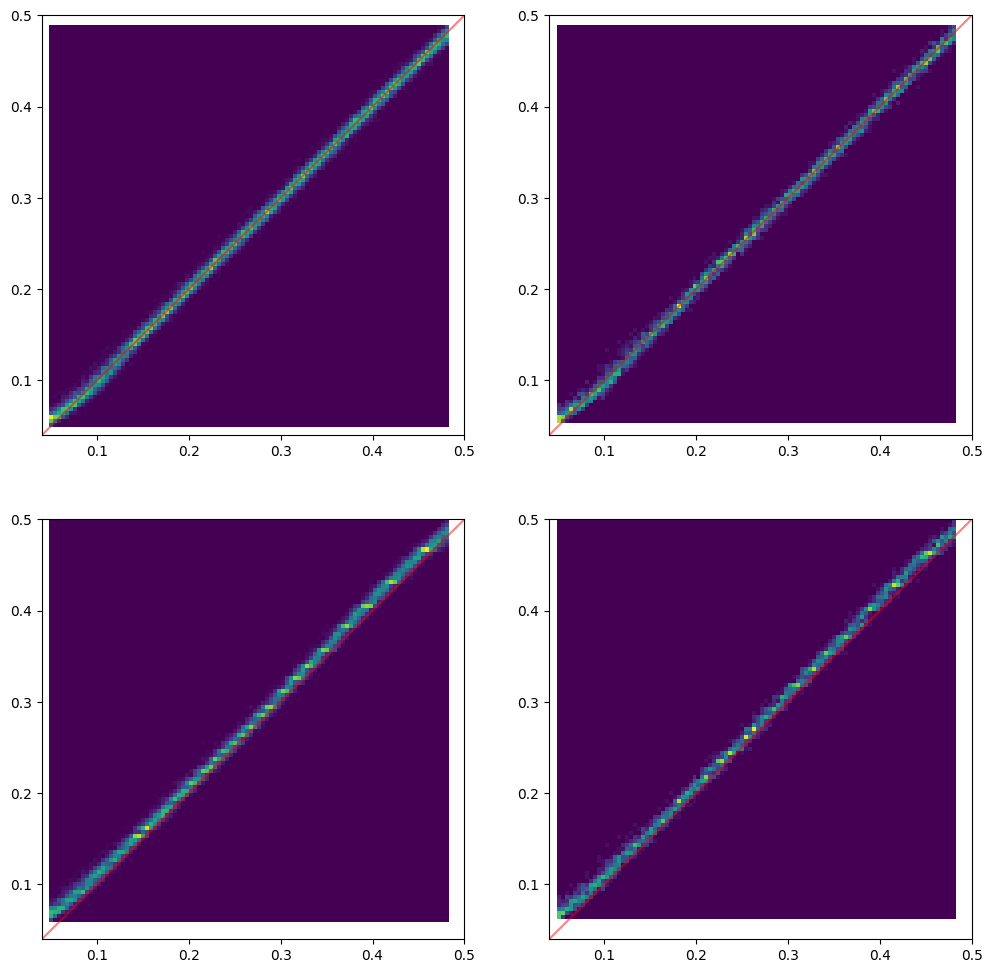

In [17]:
nbins = 100
a = 0.04; b = 0.5
for i in range(num_truths_to_use):
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2, figsize=(12,12))
    ax1.hist2d(train_truth[:,i].ravel(), train_prediction[:,i].ravel(),     bins=nbins); ax1.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax1.set_xlim(a, b); ax1.set_ylim(a, b)
    ax2.hist2d(test_truth[:,i].ravel(),  test_prediction[:,i].ravel(),      bins=nbins); ax2.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax2.set_xlim(a, b); ax2.set_ylim(a, b)
    ax3.hist2d(train_truth[:,i].ravel(), hls_train_prediction[:,i].ravel(), bins=nbins); ax3.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax3.set_xlim(a, b); ax3.set_ylim(a, b)
    ax4.hist2d(test_truth[:,i].ravel(),  hls_test_prediction[:,i].ravel(),  bins=nbins); ax4.plot([0.0, 1.0], [0.0, 1.0], color="red", alpha=0.5); ax4.set_xlim(a, b); ax4.set_ylim(a, b)
    plt.show()
    fig.savefig(name + "/hist2d." + str(truths_to_use[i]) + ".png")

In [21]:
if synth_hls:
    hls_model.build(synth=True, csim=True, cosim=True)


****** Vitis HLS - High-Level Synthesis from C, C++ and OpenCL v2023.1 (64-bit)
  **** SW Build 3854077 on May  4 2023
  **** IP Build 3864474 on Sun May  7 20:36:21 MDT 2023
  **** SharedData Build 3865790 on Sun May 07 13:33:03 MDT 2023
    ** Copyright 1986-2022 Xilinx, Inc. All Rights Reserved.
    ** Copyright 2022-2023 Advanced Micro Devices, Inc. All Rights Reserved.

source /opt/Xilinx/Vitis_HLS/2023.1/scripts/vitis_hls/hls.tcl -notrace
INFO: [HLS 200-10] Running '/opt/Xilinx/Vitis_HLS/2023.1/bin/unwrapped/lnx64.o/vitis_hls'
INFO: [HLS 200-10] For user 'root' on host 'f1486668fc0d' (Linux_x86_64 version 6.11.0-21-generic) on Mon May 05 23:25:10 EDT 2025
INFO: [HLS 200-10] In directory '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj'
Sourcing Tcl script 'build_prj.tcl'
INFO: [HLS 200-1510] Running: open_project myproject_prj 
INFO: [HLS 200-10] Creating and opening project '/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_

INFO: [HLS 214-131] Inlining function 'nnet::product::mult<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0> >::product(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>)' into 'void nnet::dense_latency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, config2::weight_t*, config2::bias_t*)' (firmware/nnet_utils/nnet_dense_latency.h:42:27)
INFO: [HLS 214-131] Inlining function 'nnet::DenseLatency<ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>, config2>::dense(ap_fixed<16, 6, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<33, 16, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*, ap_fixed<9, 2, (ap_q_mode)5, (ap_o_mode)3, 0>*)' into 'void nnet::dense<ap_fixed<16, 6, (ap_q_mode

INFO: [HLS 200-111] Finished Standard Transforms: CPU user time: 2.29 seconds. CPU system time: 0.03 seconds. Elapsed time: 2.32 seconds; current allocated memory: 1.200 GB.
INFO: [HLS 200-10] Checking synthesizability ...
INFO: [HLS 200-111] Finished Checking Synthesizability: CPU user time: 2.13 seconds. CPU system time: 0.01 seconds. Elapsed time: 2.14 seconds; current allocated memory: 1.200 GB.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:98:10) to (firmware/nnet_utils/nnet_activation.h:123:1) in function 'nnet::sigmoid<ap_fixed<28, 9, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_fixed<12, 1, (ap_q_mode)5, (ap_o_mode)3, 0>, sigmoid_config10>'... converting 3 basic blocks.
INFO: [XFORM 203-401] Performing if-conversion on hyperblock from (firmware/nnet_utils/nnet_activation.h:43:31) to (firmware/nnet_utils/nnet_activation.h:50:1) in function 'nnet::relu<ap_fixed<26, 10, (ap_q_mode)5, (ap_o_mode)3, 0>, ap_ufixed<9, 0, (ap_q_mode)4, (

INFO: [BIND 205-100] Starting micro-architecture generation ...
INFO: [BIND 205-101] Performing variable lifetime analysis.
INFO: [BIND 205-101] Exploring resource sharing.
INFO: [BIND 205-101] Binding ...
INFO: [BIND 205-100] Finished micro-architecture generation.
INFO: [HLS 200-111] Finished Binding: CPU user time: 0.11 seconds. CPU system time: 0.01 seconds. Elapsed time: 0.11 seconds; current allocated memory: 3.728 GB.
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-42] -- Implementing module 'dense_latency_ap_ufixed_9_0_4_0_0_ap_fixed_28_9_5_3_0_config8_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SCHED 204-11] Starting scheduling ...
INFO: [SCHED 204-61] Pipelining function 'dense_latency<ap_ufixed<9, 0, 4, 0, 0>, ap_fixed<28, 9, 5, 3, 0>, config8>'.
INFO: [HLS 200-1470] Pipelining result : Target II = NA, Final II = 1, Depth = 7, function 'dense_latency<ap_ufixed<9, 0, 4, 0, 0>

INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [HLS 200-10] -- Generating RTL for module 'sigmoid_ap_fixed_28_9_5_3_0_ap_fixed_12_1_5_3_0_sigmoid_config10_s' 
INFO: [HLS 200-10] ----------------------------------------------------------------
INFO: [SYN 201-210] Renamed object name 'sigmoid_ap_fixed_28_9_5_3_0_ap_fixed_12_1_5_3_0_sigmoid_config10_s_sigmoid_table_ROM_AUTO_1R' to 'sigmoid_ap_fixed_28_9_5_3_0_ap_fixed_12_1_5_3_0_sigmoid_config10_s_sigmoid_tabkb' due to the length limit 80
INFO: [HLS 200-1030] Apply Unified Pipeline Control on module 'sigmoid_ap_fixed_28_9_5_3_0_ap_fixed_12_1_5_3_0_sigmoid_config10_s' pipeline 'sigmoid<ap_fixed<28, 9, 5, 3, 0>, ap_fixed<12, 1, 5, 3, 0>, sigmoid_config10>' pipeline type 'function pipeline'
INFO: [RTGEN 206-100] Finished creating RTL model for 'sigmoid_ap_fixed_28_9_5_3_0_ap_fixed_12_1_5_3_0_sigmoid_config10_s'.
INFO: [RTMG 210-279] Implementing memory 'myproject_sigmoid_ap_fixed_28_9_5_3_0_ap_fixed

INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_5s_21_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_5s_21_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul_16s_6ns_22_2_0.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module myproject_mul_16s_6ns_22_2_0
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject.autotb.v" into library xil_defaultlib
INFO: [VRFC 10-311] analyzing module apatb_myproject_top
INFO: [VRFC 10-2263] Analyzing SystemVerilog file "/root/build/phys476/final_project/waveform_dataset/mza_try8/hls4ml_prj/myproject_prj/solution1/sim/verilog/myproject_mul

// RTL Simulation : 1 / 4000 [97.44%] @ "318000"
// RTL Simulation : 2 / 4000 [97.44%] @ "323000"
// RTL Simulation : 3 / 4000 [97.44%] @ "328000"
// RTL Simulation : 4 / 4000 [97.44%] @ "333000"
// RTL Simulation : 5 / 4000 [97.44%] @ "338000"
// RTL Simulation : 6 / 4000 [97.44%] @ "343000"
// RTL Simulation : 7 / 4000 [97.44%] @ "348000"
// RTL Simulation : 8 / 4000 [97.44%] @ "353000"
// RTL Simulation : 9 / 4000 [97.44%] @ "358000"
// RTL Simulation : 10 / 4000 [97.44%] @ "363000"
// RTL Simulation : 11 / 4000 [97.44%] @ "368000"
// RTL Simulation : 12 / 4000 [97.44%] @ "373000"
// RTL Simulation : 13 / 4000 [97.44%] @ "378000"
// RTL Simulation : 14 / 4000 [97.44%] @ "383000"
// RTL Simulation : 15 / 4000 [97.44%] @ "388000"
// RTL Simulation : 16 / 4000 [97.44%] @ "393000"
// RTL Simulation : 17 / 4000 [97.44%] @ "398000"
// RTL Simulation : 18 / 4000 [97.44%] @ "403000"
// RTL Simulation : 19 / 4000 [97.44%] @ "408000"
// RTL Simulation : 20 / 4000 [97.44%] @ "413000"
// RTL Si

// RTL Simulation : 166 / 4000 [97.44%] @ "1143000"
// RTL Simulation : 167 / 4000 [97.44%] @ "1148000"
// RTL Simulation : 168 / 4000 [97.44%] @ "1153000"
// RTL Simulation : 169 / 4000 [97.44%] @ "1158000"
// RTL Simulation : 170 / 4000 [97.44%] @ "1163000"
// RTL Simulation : 171 / 4000 [97.44%] @ "1168000"
// RTL Simulation : 172 / 4000 [97.44%] @ "1173000"
// RTL Simulation : 173 / 4000 [97.44%] @ "1178000"
// RTL Simulation : 174 / 4000 [97.44%] @ "1183000"
// RTL Simulation : 175 / 4000 [97.44%] @ "1188000"
// RTL Simulation : 176 / 4000 [97.44%] @ "1193000"
// RTL Simulation : 177 / 4000 [97.44%] @ "1198000"
// RTL Simulation : 178 / 4000 [97.44%] @ "1203000"
// RTL Simulation : 179 / 4000 [97.44%] @ "1208000"
// RTL Simulation : 180 / 4000 [97.44%] @ "1213000"
// RTL Simulation : 181 / 4000 [97.44%] @ "1218000"
// RTL Simulation : 182 / 4000 [97.44%] @ "1223000"
// RTL Simulation : 183 / 4000 [97.44%] @ "1228000"
// RTL Simulation : 184 / 4000 [97.44%] @ "1233000"
// RTL Simul

// RTL Simulation : 331 / 4000 [97.44%] @ "1968000"
// RTL Simulation : 332 / 4000 [97.44%] @ "1973000"
// RTL Simulation : 333 / 4000 [97.44%] @ "1978000"
// RTL Simulation : 334 / 4000 [97.44%] @ "1983000"
// RTL Simulation : 335 / 4000 [97.44%] @ "1988000"
// RTL Simulation : 336 / 4000 [97.44%] @ "1993000"
// RTL Simulation : 337 / 4000 [97.44%] @ "1998000"
// RTL Simulation : 338 / 4000 [97.44%] @ "2003000"
// RTL Simulation : 339 / 4000 [97.44%] @ "2008000"
// RTL Simulation : 340 / 4000 [97.44%] @ "2013000"
// RTL Simulation : 341 / 4000 [97.44%] @ "2018000"
// RTL Simulation : 342 / 4000 [97.44%] @ "2023000"
// RTL Simulation : 343 / 4000 [97.44%] @ "2028000"
// RTL Simulation : 344 / 4000 [97.44%] @ "2033000"
// RTL Simulation : 345 / 4000 [97.44%] @ "2038000"
// RTL Simulation : 346 / 4000 [97.44%] @ "2043000"
// RTL Simulation : 347 / 4000 [97.44%] @ "2048000"
// RTL Simulation : 348 / 4000 [97.44%] @ "2053000"
// RTL Simulation : 349 / 4000 [97.44%] @ "2058000"
// RTL Simul

// RTL Simulation : 496 / 4000 [97.44%] @ "2793000"
// RTL Simulation : 497 / 4000 [97.44%] @ "2798000"
// RTL Simulation : 498 / 4000 [97.44%] @ "2803000"
// RTL Simulation : 499 / 4000 [97.44%] @ "2808000"
// RTL Simulation : 500 / 4000 [97.44%] @ "2813000"
// RTL Simulation : 501 / 4000 [97.44%] @ "2818000"
// RTL Simulation : 502 / 4000 [97.44%] @ "2823000"
// RTL Simulation : 503 / 4000 [97.44%] @ "2828000"
// RTL Simulation : 504 / 4000 [97.44%] @ "2833000"
// RTL Simulation : 505 / 4000 [97.44%] @ "2838000"
// RTL Simulation : 506 / 4000 [97.44%] @ "2843000"
// RTL Simulation : 507 / 4000 [97.44%] @ "2848000"
// RTL Simulation : 508 / 4000 [97.44%] @ "2853000"
// RTL Simulation : 509 / 4000 [97.44%] @ "2858000"
// RTL Simulation : 510 / 4000 [97.44%] @ "2863000"
// RTL Simulation : 511 / 4000 [97.44%] @ "2868000"
// RTL Simulation : 512 / 4000 [97.44%] @ "2873000"
// RTL Simulation : 513 / 4000 [97.44%] @ "2878000"
// RTL Simulation : 514 / 4000 [97.44%] @ "2883000"
// RTL Simul

// RTL Simulation : 661 / 4000 [97.44%] @ "3618000"
// RTL Simulation : 662 / 4000 [97.44%] @ "3623000"
// RTL Simulation : 663 / 4000 [97.44%] @ "3628000"
// RTL Simulation : 664 / 4000 [97.44%] @ "3633000"
// RTL Simulation : 665 / 4000 [97.44%] @ "3638000"
// RTL Simulation : 666 / 4000 [97.44%] @ "3643000"
// RTL Simulation : 667 / 4000 [97.44%] @ "3648000"
// RTL Simulation : 668 / 4000 [97.44%] @ "3653000"
// RTL Simulation : 669 / 4000 [97.44%] @ "3658000"
// RTL Simulation : 670 / 4000 [97.44%] @ "3663000"
// RTL Simulation : 671 / 4000 [97.44%] @ "3668000"
// RTL Simulation : 672 / 4000 [97.44%] @ "3673000"
// RTL Simulation : 673 / 4000 [97.44%] @ "3678000"
// RTL Simulation : 674 / 4000 [97.44%] @ "3683000"
// RTL Simulation : 675 / 4000 [97.44%] @ "3688000"
// RTL Simulation : 676 / 4000 [97.44%] @ "3693000"
// RTL Simulation : 677 / 4000 [97.44%] @ "3698000"
// RTL Simulation : 678 / 4000 [97.44%] @ "3703000"
// RTL Simulation : 679 / 4000 [97.44%] @ "3708000"
// RTL Simul

// RTL Simulation : 826 / 4000 [97.44%] @ "4443000"
// RTL Simulation : 827 / 4000 [97.44%] @ "4448000"
// RTL Simulation : 828 / 4000 [97.44%] @ "4453000"
// RTL Simulation : 829 / 4000 [97.44%] @ "4458000"
// RTL Simulation : 830 / 4000 [97.44%] @ "4463000"
// RTL Simulation : 831 / 4000 [97.44%] @ "4468000"
// RTL Simulation : 832 / 4000 [97.44%] @ "4473000"
// RTL Simulation : 833 / 4000 [97.44%] @ "4478000"
// RTL Simulation : 834 / 4000 [97.44%] @ "4483000"
// RTL Simulation : 835 / 4000 [97.44%] @ "4488000"
// RTL Simulation : 836 / 4000 [97.44%] @ "4493000"
// RTL Simulation : 837 / 4000 [97.44%] @ "4498000"
// RTL Simulation : 838 / 4000 [97.44%] @ "4503000"
// RTL Simulation : 839 / 4000 [97.44%] @ "4508000"
// RTL Simulation : 840 / 4000 [97.44%] @ "4513000"
// RTL Simulation : 841 / 4000 [97.44%] @ "4518000"
// RTL Simulation : 842 / 4000 [97.44%] @ "4523000"
// RTL Simulation : 843 / 4000 [97.44%] @ "4528000"
// RTL Simulation : 844 / 4000 [97.44%] @ "4533000"
// RTL Simul

// RTL Simulation : 991 / 4000 [97.44%] @ "5268000"
// RTL Simulation : 992 / 4000 [97.44%] @ "5273000"
// RTL Simulation : 993 / 4000 [97.44%] @ "5278000"
// RTL Simulation : 994 / 4000 [97.44%] @ "5283000"
// RTL Simulation : 995 / 4000 [97.44%] @ "5288000"
// RTL Simulation : 996 / 4000 [97.44%] @ "5293000"
// RTL Simulation : 997 / 4000 [97.44%] @ "5298000"
// RTL Simulation : 998 / 4000 [97.44%] @ "5303000"
// RTL Simulation : 999 / 4000 [97.44%] @ "5308000"
// RTL Simulation : 1000 / 4000 [97.44%] @ "5313000"
// RTL Simulation : 1001 / 4000 [97.44%] @ "5318000"
// RTL Simulation : 1002 / 4000 [97.44%] @ "5323000"
// RTL Simulation : 1003 / 4000 [97.44%] @ "5328000"
// RTL Simulation : 1004 / 4000 [97.44%] @ "5333000"
// RTL Simulation : 1005 / 4000 [97.44%] @ "5338000"
// RTL Simulation : 1006 / 4000 [97.44%] @ "5343000"
// RTL Simulation : 1007 / 4000 [97.44%] @ "5348000"
// RTL Simulation : 1008 / 4000 [97.44%] @ "5353000"
// RTL Simulation : 1009 / 4000 [97.44%] @ "5358000"
//

// RTL Simulation : 1156 / 4000 [97.44%] @ "6093000"
// RTL Simulation : 1157 / 4000 [97.44%] @ "6098000"
// RTL Simulation : 1158 / 4000 [97.44%] @ "6103000"
// RTL Simulation : 1159 / 4000 [97.44%] @ "6108000"
// RTL Simulation : 1160 / 4000 [97.44%] @ "6113000"
// RTL Simulation : 1161 / 4000 [97.44%] @ "6118000"
// RTL Simulation : 1162 / 4000 [97.44%] @ "6123000"
// RTL Simulation : 1163 / 4000 [97.44%] @ "6128000"
// RTL Simulation : 1164 / 4000 [97.44%] @ "6133000"
// RTL Simulation : 1165 / 4000 [97.44%] @ "6138000"
// RTL Simulation : 1166 / 4000 [97.44%] @ "6143000"
// RTL Simulation : 1167 / 4000 [97.44%] @ "6148000"
// RTL Simulation : 1168 / 4000 [97.44%] @ "6153000"
// RTL Simulation : 1169 / 4000 [97.44%] @ "6158000"
// RTL Simulation : 1170 / 4000 [97.44%] @ "6163000"
// RTL Simulation : 1171 / 4000 [97.44%] @ "6168000"
// RTL Simulation : 1172 / 4000 [97.44%] @ "6173000"
// RTL Simulation : 1173 / 4000 [97.44%] @ "6178000"
// RTL Simulation : 1174 / 4000 [97.44%] @ "61

// RTL Simulation : 1321 / 4000 [97.44%] @ "6918000"
// RTL Simulation : 1322 / 4000 [97.44%] @ "6923000"
// RTL Simulation : 1323 / 4000 [97.44%] @ "6928000"
// RTL Simulation : 1324 / 4000 [97.44%] @ "6933000"
// RTL Simulation : 1325 / 4000 [97.44%] @ "6938000"
// RTL Simulation : 1326 / 4000 [97.44%] @ "6943000"
// RTL Simulation : 1327 / 4000 [97.44%] @ "6948000"
// RTL Simulation : 1328 / 4000 [97.44%] @ "6953000"
// RTL Simulation : 1329 / 4000 [97.44%] @ "6958000"
// RTL Simulation : 1330 / 4000 [97.44%] @ "6963000"
// RTL Simulation : 1331 / 4000 [97.44%] @ "6968000"
// RTL Simulation : 1332 / 4000 [97.44%] @ "6973000"
// RTL Simulation : 1333 / 4000 [97.44%] @ "6978000"
// RTL Simulation : 1334 / 4000 [97.44%] @ "6983000"
// RTL Simulation : 1335 / 4000 [97.44%] @ "6988000"
// RTL Simulation : 1336 / 4000 [97.44%] @ "6993000"
// RTL Simulation : 1337 / 4000 [97.44%] @ "6998000"
// RTL Simulation : 1338 / 4000 [97.44%] @ "7003000"
// RTL Simulation : 1339 / 4000 [97.44%] @ "70

// RTL Simulation : 1486 / 4000 [97.44%] @ "7743000"
// RTL Simulation : 1487 / 4000 [97.44%] @ "7748000"
// RTL Simulation : 1488 / 4000 [97.44%] @ "7753000"
// RTL Simulation : 1489 / 4000 [97.44%] @ "7758000"
// RTL Simulation : 1490 / 4000 [97.44%] @ "7763000"
// RTL Simulation : 1491 / 4000 [97.44%] @ "7768000"
// RTL Simulation : 1492 / 4000 [97.44%] @ "7773000"
// RTL Simulation : 1493 / 4000 [97.44%] @ "7778000"
// RTL Simulation : 1494 / 4000 [97.44%] @ "7783000"
// RTL Simulation : 1495 / 4000 [97.44%] @ "7788000"
// RTL Simulation : 1496 / 4000 [97.44%] @ "7793000"
// RTL Simulation : 1497 / 4000 [97.44%] @ "7798000"
// RTL Simulation : 1498 / 4000 [97.44%] @ "7803000"
// RTL Simulation : 1499 / 4000 [97.44%] @ "7808000"
// RTL Simulation : 1500 / 4000 [97.44%] @ "7813000"
// RTL Simulation : 1501 / 4000 [97.44%] @ "7818000"
// RTL Simulation : 1502 / 4000 [97.44%] @ "7823000"
// RTL Simulation : 1503 / 4000 [97.44%] @ "7828000"
// RTL Simulation : 1504 / 4000 [97.44%] @ "78

// RTL Simulation : 1651 / 4000 [97.44%] @ "8568000"
// RTL Simulation : 1652 / 4000 [97.44%] @ "8573000"
// RTL Simulation : 1653 / 4000 [97.44%] @ "8578000"
// RTL Simulation : 1654 / 4000 [97.44%] @ "8583000"
// RTL Simulation : 1655 / 4000 [97.44%] @ "8588000"
// RTL Simulation : 1656 / 4000 [97.44%] @ "8593000"
// RTL Simulation : 1657 / 4000 [97.44%] @ "8598000"
// RTL Simulation : 1658 / 4000 [97.44%] @ "8603000"
// RTL Simulation : 1659 / 4000 [97.44%] @ "8608000"
// RTL Simulation : 1660 / 4000 [97.44%] @ "8613000"
// RTL Simulation : 1661 / 4000 [97.44%] @ "8618000"
// RTL Simulation : 1662 / 4000 [97.44%] @ "8623000"
// RTL Simulation : 1663 / 4000 [97.44%] @ "8628000"
// RTL Simulation : 1664 / 4000 [97.44%] @ "8633000"
// RTL Simulation : 1665 / 4000 [97.44%] @ "8638000"
// RTL Simulation : 1666 / 4000 [97.44%] @ "8643000"
// RTL Simulation : 1667 / 4000 [97.44%] @ "8648000"
// RTL Simulation : 1668 / 4000 [97.44%] @ "8653000"
// RTL Simulation : 1669 / 4000 [97.44%] @ "86

// RTL Simulation : 1816 / 4000 [97.44%] @ "9393000"
// RTL Simulation : 1817 / 4000 [97.44%] @ "9398000"
// RTL Simulation : 1818 / 4000 [97.44%] @ "9403000"
// RTL Simulation : 1819 / 4000 [97.44%] @ "9408000"
// RTL Simulation : 1820 / 4000 [97.44%] @ "9413000"
// RTL Simulation : 1821 / 4000 [97.44%] @ "9418000"
// RTL Simulation : 1822 / 4000 [97.44%] @ "9423000"
// RTL Simulation : 1823 / 4000 [97.44%] @ "9428000"
// RTL Simulation : 1824 / 4000 [97.44%] @ "9433000"
// RTL Simulation : 1825 / 4000 [97.44%] @ "9438000"
// RTL Simulation : 1826 / 4000 [97.44%] @ "9443000"
// RTL Simulation : 1827 / 4000 [97.44%] @ "9448000"
// RTL Simulation : 1828 / 4000 [97.44%] @ "9453000"
// RTL Simulation : 1829 / 4000 [97.44%] @ "9458000"
// RTL Simulation : 1830 / 4000 [97.44%] @ "9463000"
// RTL Simulation : 1831 / 4000 [97.44%] @ "9468000"
// RTL Simulation : 1832 / 4000 [97.44%] @ "9473000"
// RTL Simulation : 1833 / 4000 [97.44%] @ "9478000"
// RTL Simulation : 1834 / 4000 [97.44%] @ "94

// RTL Simulation : 1981 / 4000 [97.44%] @ "10218000"
// RTL Simulation : 1982 / 4000 [97.44%] @ "10223000"
// RTL Simulation : 1983 / 4000 [97.44%] @ "10228000"
// RTL Simulation : 1984 / 4000 [97.44%] @ "10233000"
// RTL Simulation : 1985 / 4000 [97.44%] @ "10238000"
// RTL Simulation : 1986 / 4000 [97.44%] @ "10243000"
// RTL Simulation : 1987 / 4000 [97.44%] @ "10248000"
// RTL Simulation : 1988 / 4000 [97.44%] @ "10253000"
// RTL Simulation : 1989 / 4000 [97.44%] @ "10258000"
// RTL Simulation : 1990 / 4000 [97.44%] @ "10263000"
// RTL Simulation : 1991 / 4000 [97.44%] @ "10268000"
// RTL Simulation : 1992 / 4000 [97.44%] @ "10273000"
// RTL Simulation : 1993 / 4000 [97.44%] @ "10278000"
// RTL Simulation : 1994 / 4000 [97.44%] @ "10283000"
// RTL Simulation : 1995 / 4000 [97.44%] @ "10288000"
// RTL Simulation : 1996 / 4000 [97.44%] @ "10293000"
// RTL Simulation : 1997 / 4000 [97.44%] @ "10298000"
// RTL Simulation : 1998 / 4000 [97.44%] @ "10303000"
// RTL Simulation : 1999 / 4

// RTL Simulation : 2146 / 4000 [97.44%] @ "11043000"
// RTL Simulation : 2147 / 4000 [97.44%] @ "11048000"
// RTL Simulation : 2148 / 4000 [97.44%] @ "11053000"
// RTL Simulation : 2149 / 4000 [97.44%] @ "11058000"
// RTL Simulation : 2150 / 4000 [97.44%] @ "11063000"
// RTL Simulation : 2151 / 4000 [97.44%] @ "11068000"
// RTL Simulation : 2152 / 4000 [97.44%] @ "11073000"
// RTL Simulation : 2153 / 4000 [97.44%] @ "11078000"
// RTL Simulation : 2154 / 4000 [97.44%] @ "11083000"
// RTL Simulation : 2155 / 4000 [97.44%] @ "11088000"
// RTL Simulation : 2156 / 4000 [97.44%] @ "11093000"
// RTL Simulation : 2157 / 4000 [97.44%] @ "11098000"
// RTL Simulation : 2158 / 4000 [97.44%] @ "11103000"
// RTL Simulation : 2159 / 4000 [97.44%] @ "11108000"
// RTL Simulation : 2160 / 4000 [97.44%] @ "11113000"
// RTL Simulation : 2161 / 4000 [97.44%] @ "11118000"
// RTL Simulation : 2162 / 4000 [97.44%] @ "11123000"
// RTL Simulation : 2163 / 4000 [97.44%] @ "11128000"
// RTL Simulation : 2164 / 4

// RTL Simulation : 2311 / 4000 [97.44%] @ "11868000"
// RTL Simulation : 2312 / 4000 [97.44%] @ "11873000"
// RTL Simulation : 2313 / 4000 [97.44%] @ "11878000"
// RTL Simulation : 2314 / 4000 [97.44%] @ "11883000"
// RTL Simulation : 2315 / 4000 [97.44%] @ "11888000"
// RTL Simulation : 2316 / 4000 [97.44%] @ "11893000"
// RTL Simulation : 2317 / 4000 [97.44%] @ "11898000"
// RTL Simulation : 2318 / 4000 [97.44%] @ "11903000"
// RTL Simulation : 2319 / 4000 [97.44%] @ "11908000"
// RTL Simulation : 2320 / 4000 [97.44%] @ "11913000"
// RTL Simulation : 2321 / 4000 [97.44%] @ "11918000"
// RTL Simulation : 2322 / 4000 [97.44%] @ "11923000"
// RTL Simulation : 2323 / 4000 [97.44%] @ "11928000"
// RTL Simulation : 2324 / 4000 [97.44%] @ "11933000"
// RTL Simulation : 2325 / 4000 [97.44%] @ "11938000"
// RTL Simulation : 2326 / 4000 [97.44%] @ "11943000"
// RTL Simulation : 2327 / 4000 [97.44%] @ "11948000"
// RTL Simulation : 2328 / 4000 [97.44%] @ "11953000"
// RTL Simulation : 2329 / 4

// RTL Simulation : 2476 / 4000 [97.44%] @ "12693000"
// RTL Simulation : 2477 / 4000 [97.44%] @ "12698000"
// RTL Simulation : 2478 / 4000 [97.44%] @ "12703000"
// RTL Simulation : 2479 / 4000 [97.44%] @ "12708000"
// RTL Simulation : 2480 / 4000 [97.44%] @ "12713000"
// RTL Simulation : 2481 / 4000 [97.44%] @ "12718000"
// RTL Simulation : 2482 / 4000 [97.44%] @ "12723000"
// RTL Simulation : 2483 / 4000 [97.44%] @ "12728000"
// RTL Simulation : 2484 / 4000 [97.44%] @ "12733000"
// RTL Simulation : 2485 / 4000 [97.44%] @ "12738000"
// RTL Simulation : 2486 / 4000 [97.44%] @ "12743000"
// RTL Simulation : 2487 / 4000 [97.44%] @ "12748000"
// RTL Simulation : 2488 / 4000 [97.44%] @ "12753000"
// RTL Simulation : 2489 / 4000 [97.44%] @ "12758000"
// RTL Simulation : 2490 / 4000 [97.44%] @ "12763000"
// RTL Simulation : 2491 / 4000 [97.44%] @ "12768000"
// RTL Simulation : 2492 / 4000 [97.44%] @ "12773000"
// RTL Simulation : 2493 / 4000 [97.44%] @ "12778000"
// RTL Simulation : 2494 / 4

// RTL Simulation : 2641 / 4000 [97.44%] @ "13518000"
// RTL Simulation : 2642 / 4000 [97.44%] @ "13523000"
// RTL Simulation : 2643 / 4000 [97.44%] @ "13528000"
// RTL Simulation : 2644 / 4000 [97.44%] @ "13533000"
// RTL Simulation : 2645 / 4000 [97.44%] @ "13538000"
// RTL Simulation : 2646 / 4000 [97.44%] @ "13543000"
// RTL Simulation : 2647 / 4000 [97.44%] @ "13548000"
// RTL Simulation : 2648 / 4000 [97.44%] @ "13553000"
// RTL Simulation : 2649 / 4000 [97.44%] @ "13558000"
// RTL Simulation : 2650 / 4000 [97.44%] @ "13563000"
// RTL Simulation : 2651 / 4000 [97.44%] @ "13568000"
// RTL Simulation : 2652 / 4000 [97.44%] @ "13573000"
// RTL Simulation : 2653 / 4000 [97.44%] @ "13578000"
// RTL Simulation : 2654 / 4000 [97.44%] @ "13583000"
// RTL Simulation : 2655 / 4000 [97.44%] @ "13588000"
// RTL Simulation : 2656 / 4000 [97.44%] @ "13593000"
// RTL Simulation : 2657 / 4000 [97.44%] @ "13598000"
// RTL Simulation : 2658 / 4000 [97.44%] @ "13603000"
// RTL Simulation : 2659 / 4

// RTL Simulation : 2806 / 4000 [97.44%] @ "14343000"
// RTL Simulation : 2807 / 4000 [97.44%] @ "14348000"
// RTL Simulation : 2808 / 4000 [97.44%] @ "14353000"
// RTL Simulation : 2809 / 4000 [97.44%] @ "14358000"
// RTL Simulation : 2810 / 4000 [97.44%] @ "14363000"
// RTL Simulation : 2811 / 4000 [97.44%] @ "14368000"
// RTL Simulation : 2812 / 4000 [97.44%] @ "14373000"
// RTL Simulation : 2813 / 4000 [97.44%] @ "14378000"
// RTL Simulation : 2814 / 4000 [97.44%] @ "14383000"
// RTL Simulation : 2815 / 4000 [97.44%] @ "14388000"
// RTL Simulation : 2816 / 4000 [97.44%] @ "14393000"
// RTL Simulation : 2817 / 4000 [97.44%] @ "14398000"
// RTL Simulation : 2818 / 4000 [97.44%] @ "14403000"
// RTL Simulation : 2819 / 4000 [97.44%] @ "14408000"
// RTL Simulation : 2820 / 4000 [97.44%] @ "14413000"
// RTL Simulation : 2821 / 4000 [97.44%] @ "14418000"
// RTL Simulation : 2822 / 4000 [97.44%] @ "14423000"
// RTL Simulation : 2823 / 4000 [97.44%] @ "14428000"
// RTL Simulation : 2824 / 4

// RTL Simulation : 2971 / 4000 [97.44%] @ "15168000"
// RTL Simulation : 2972 / 4000 [97.44%] @ "15173000"
// RTL Simulation : 2973 / 4000 [97.44%] @ "15178000"
// RTL Simulation : 2974 / 4000 [97.44%] @ "15183000"
// RTL Simulation : 2975 / 4000 [97.44%] @ "15188000"
// RTL Simulation : 2976 / 4000 [97.44%] @ "15193000"
// RTL Simulation : 2977 / 4000 [97.44%] @ "15198000"
// RTL Simulation : 2978 / 4000 [97.44%] @ "15203000"
// RTL Simulation : 2979 / 4000 [97.44%] @ "15208000"
// RTL Simulation : 2980 / 4000 [97.44%] @ "15213000"
// RTL Simulation : 2981 / 4000 [97.44%] @ "15218000"
// RTL Simulation : 2982 / 4000 [97.44%] @ "15223000"
// RTL Simulation : 2983 / 4000 [97.44%] @ "15228000"
// RTL Simulation : 2984 / 4000 [97.44%] @ "15233000"
// RTL Simulation : 2985 / 4000 [97.44%] @ "15238000"
// RTL Simulation : 2986 / 4000 [97.44%] @ "15243000"
// RTL Simulation : 2987 / 4000 [97.44%] @ "15248000"
// RTL Simulation : 2988 / 4000 [97.44%] @ "15253000"
// RTL Simulation : 2989 / 4

// RTL Simulation : 3136 / 4000 [97.44%] @ "15993000"
// RTL Simulation : 3137 / 4000 [97.44%] @ "15998000"
// RTL Simulation : 3138 / 4000 [97.44%] @ "16003000"
// RTL Simulation : 3139 / 4000 [97.44%] @ "16008000"
// RTL Simulation : 3140 / 4000 [97.44%] @ "16013000"
// RTL Simulation : 3141 / 4000 [97.44%] @ "16018000"
// RTL Simulation : 3142 / 4000 [97.44%] @ "16023000"
// RTL Simulation : 3143 / 4000 [97.44%] @ "16028000"
// RTL Simulation : 3144 / 4000 [97.44%] @ "16033000"
// RTL Simulation : 3145 / 4000 [97.44%] @ "16038000"
// RTL Simulation : 3146 / 4000 [97.44%] @ "16043000"
// RTL Simulation : 3147 / 4000 [97.44%] @ "16048000"
// RTL Simulation : 3148 / 4000 [97.44%] @ "16053000"
// RTL Simulation : 3149 / 4000 [97.44%] @ "16058000"
// RTL Simulation : 3150 / 4000 [97.44%] @ "16063000"
// RTL Simulation : 3151 / 4000 [97.44%] @ "16068000"
// RTL Simulation : 3152 / 4000 [97.44%] @ "16073000"
// RTL Simulation : 3153 / 4000 [97.44%] @ "16078000"
// RTL Simulation : 3154 / 4

// RTL Simulation : 3301 / 4000 [97.44%] @ "16818000"
// RTL Simulation : 3302 / 4000 [97.44%] @ "16823000"
// RTL Simulation : 3303 / 4000 [97.44%] @ "16828000"
// RTL Simulation : 3304 / 4000 [97.44%] @ "16833000"
// RTL Simulation : 3305 / 4000 [97.44%] @ "16838000"
// RTL Simulation : 3306 / 4000 [97.44%] @ "16843000"
// RTL Simulation : 3307 / 4000 [97.44%] @ "16848000"
// RTL Simulation : 3308 / 4000 [97.44%] @ "16853000"
// RTL Simulation : 3309 / 4000 [97.44%] @ "16858000"
// RTL Simulation : 3310 / 4000 [97.44%] @ "16863000"
// RTL Simulation : 3311 / 4000 [97.44%] @ "16868000"
// RTL Simulation : 3312 / 4000 [97.44%] @ "16873000"
// RTL Simulation : 3313 / 4000 [97.44%] @ "16878000"
// RTL Simulation : 3314 / 4000 [97.44%] @ "16883000"
// RTL Simulation : 3315 / 4000 [97.44%] @ "16888000"
// RTL Simulation : 3316 / 4000 [97.44%] @ "16893000"
// RTL Simulation : 3317 / 4000 [97.44%] @ "16898000"
// RTL Simulation : 3318 / 4000 [97.44%] @ "16903000"
// RTL Simulation : 3319 / 4

// RTL Simulation : 3466 / 4000 [97.44%] @ "17643000"
// RTL Simulation : 3467 / 4000 [97.44%] @ "17648000"
// RTL Simulation : 3468 / 4000 [97.44%] @ "17653000"
// RTL Simulation : 3469 / 4000 [97.44%] @ "17658000"
// RTL Simulation : 3470 / 4000 [97.44%] @ "17663000"
// RTL Simulation : 3471 / 4000 [97.44%] @ "17668000"
// RTL Simulation : 3472 / 4000 [97.44%] @ "17673000"
// RTL Simulation : 3473 / 4000 [97.44%] @ "17678000"
// RTL Simulation : 3474 / 4000 [97.44%] @ "17683000"
// RTL Simulation : 3475 / 4000 [97.44%] @ "17688000"
// RTL Simulation : 3476 / 4000 [97.44%] @ "17693000"
// RTL Simulation : 3477 / 4000 [97.44%] @ "17698000"
// RTL Simulation : 3478 / 4000 [97.44%] @ "17703000"
// RTL Simulation : 3479 / 4000 [97.44%] @ "17708000"
// RTL Simulation : 3480 / 4000 [97.44%] @ "17713000"
// RTL Simulation : 3481 / 4000 [97.44%] @ "17718000"
// RTL Simulation : 3482 / 4000 [97.44%] @ "17723000"
// RTL Simulation : 3483 / 4000 [97.44%] @ "17728000"
// RTL Simulation : 3484 / 4

// RTL Simulation : 3631 / 4000 [97.44%] @ "18468000"
// RTL Simulation : 3632 / 4000 [97.44%] @ "18473000"
// RTL Simulation : 3633 / 4000 [97.44%] @ "18478000"
// RTL Simulation : 3634 / 4000 [97.44%] @ "18483000"
// RTL Simulation : 3635 / 4000 [97.44%] @ "18488000"
// RTL Simulation : 3636 / 4000 [97.44%] @ "18493000"
// RTL Simulation : 3637 / 4000 [97.44%] @ "18498000"
// RTL Simulation : 3638 / 4000 [97.44%] @ "18503000"
// RTL Simulation : 3639 / 4000 [97.44%] @ "18508000"
// RTL Simulation : 3640 / 4000 [97.44%] @ "18513000"
// RTL Simulation : 3641 / 4000 [97.44%] @ "18518000"
// RTL Simulation : 3642 / 4000 [97.44%] @ "18523000"
// RTL Simulation : 3643 / 4000 [97.44%] @ "18528000"
// RTL Simulation : 3644 / 4000 [97.44%] @ "18533000"
// RTL Simulation : 3645 / 4000 [97.44%] @ "18538000"
// RTL Simulation : 3646 / 4000 [97.44%] @ "18543000"
// RTL Simulation : 3647 / 4000 [97.44%] @ "18548000"
// RTL Simulation : 3648 / 4000 [97.44%] @ "18553000"
// RTL Simulation : 3649 / 4

// RTL Simulation : 3796 / 4000 [97.44%] @ "19293000"
// RTL Simulation : 3797 / 4000 [97.44%] @ "19298000"
// RTL Simulation : 3798 / 4000 [97.44%] @ "19303000"
// RTL Simulation : 3799 / 4000 [97.44%] @ "19308000"
// RTL Simulation : 3800 / 4000 [97.44%] @ "19313000"
// RTL Simulation : 3801 / 4000 [97.44%] @ "19318000"
// RTL Simulation : 3802 / 4000 [97.44%] @ "19323000"
// RTL Simulation : 3803 / 4000 [97.44%] @ "19328000"
// RTL Simulation : 3804 / 4000 [97.44%] @ "19333000"
// RTL Simulation : 3805 / 4000 [97.44%] @ "19338000"
// RTL Simulation : 3806 / 4000 [97.44%] @ "19343000"
// RTL Simulation : 3807 / 4000 [97.44%] @ "19348000"
// RTL Simulation : 3808 / 4000 [97.44%] @ "19353000"
// RTL Simulation : 3809 / 4000 [97.44%] @ "19358000"
// RTL Simulation : 3810 / 4000 [97.44%] @ "19363000"
// RTL Simulation : 3811 / 4000 [97.44%] @ "19368000"
// RTL Simulation : 3812 / 4000 [97.44%] @ "19373000"
// RTL Simulation : 3813 / 4000 [97.44%] @ "19378000"
// RTL Simulation : 3814 / 4

// RTL Simulation : 3961 / 4000 [97.44%] @ "20118000"
// RTL Simulation : 3962 / 4000 [97.44%] @ "20123000"
// RTL Simulation : 3963 / 4000 [97.44%] @ "20128000"
// RTL Simulation : 3964 / 4000 [97.44%] @ "20133000"
// RTL Simulation : 3965 / 4000 [97.44%] @ "20138000"
// RTL Simulation : 3966 / 4000 [97.44%] @ "20143000"
// RTL Simulation : 3967 / 4000 [97.44%] @ "20148000"
// RTL Simulation : 3968 / 4000 [97.44%] @ "20153000"
// RTL Simulation : 3969 / 4000 [97.44%] @ "20158000"
// RTL Simulation : 3970 / 4000 [97.44%] @ "20163000"
// RTL Simulation : 3971 / 4000 [97.44%] @ "20168000"
// RTL Simulation : 3972 / 4000 [97.44%] @ "20173000"
// RTL Simulation : 3973 / 4000 [97.44%] @ "20178000"
// RTL Simulation : 3974 / 4000 [97.44%] @ "20183000"
// RTL Simulation : 3975 / 4000 [97.44%] @ "20188000"
// RTL Simulation : 3976 / 4000 [97.44%] @ "20193000"
// RTL Simulation : 3977 / 4000 [97.44%] @ "20198000"
// RTL Simulation : 3978 / 4000 [97.44%] @ "20203000"
// RTL Simulation : 3979 / 4

In [22]:
if synth_hls:
    hls4ml.report.read_vivado_report(name + '/hls4ml_prj') # requires 1911 DSPs

Found 1 solution(s) in mza_try8/hls4ml_prj/myproject_prj.
Reports for solution "solution1":

C SIMULATION RESULT:
INFO: [SIM 2] *************** CSIM start ***************
INFO: [SIM 4] CSIM will launch GCC as the compiler.
   Compiling ../../../../myproject_test.cpp in debug mode
   Compiling ../../../../firmware/myproject.cpp in debug mode
   Generating csim.exe
Processing input 0
Predictions
0.399279 
Quantized predictions
0.407227 
INFO: Saved inference results to file: tb_data/csim_results.log
INFO: [SIM 1] CSim done with 0 errors.
INFO: [SIM 3] *************** CSIM finish ***************

SYNTHESIS REPORT:
== Vitis HLS Report for 'myproject'
* Date:           Mon May  5 23:43:20 2025

* Version:        2023.1 (Build 3854077 on May  4 2023)
* Project:        myproject_prj
* Solution:       solution1 (Vivado IP Flow Target)
* Product family: zynq
* Target device:  xc7z020-clg400-1


== Performance Estimates
+ Timing: 
    * Summary: 
    +--------+---------+----------+------------+
